In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import shapely.geometry as geometry
import shapely.ops as so
from Dynamic import DynamicMap
from Camera import Camera
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# Position
map_size = [30, 20]
x0 = [5, 5]
xf = [25, 5]
# static_obstacle_position: [anchor point, width, height]
static_obstacle_pos = [[[10, 0], 10, 15]]
dynamic_obstacle_pos = [[10, 15], [20, 15]]
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
iter_max = 1000
tMax = 100
vmax = 2.5
max_time = 2.5

In [41]:
tilt_limit = np.array([[np.deg2rad(0), np.deg2rad(180)], [np.deg2rad(0), np.deg2rad(180)]]) #[upper, lower]
fov_ang = np.deg2rad(30)
fov_rng = 7.5
panSpeed = [-np.deg2rad(10), np.deg2rad(5)]

In [4]:
# Test case
# Vehicle Spec
vehicle = {}
vehicle['v'] = 2
vehicle['radius'] = 0.5
t = [200, .25, 500]

# Map
map_in = {}
# Static Map
map_in['st'] = {}
map_in['st']['size'] = np.array([0, 30, 0, 20])
# Single buliding example
map_in['st']['n'] = 1
map_in['st']['0'] = np.array([(10,0), (10,15), (20,15), (20,0)])

# Dynamic Map
# This is a continuous function generates camera FOV coverages
# Input is map_in, and time input t_in
map_in['n'] = t[0]

# Single camera example, surveying final location xfin
# Camera Position
cam_x = np.array([10, 20])
cam_y = np.array([15, 15])
cam_dict = {}
cam_dict['n'] = len(cam_x)
map_in['ncam'] = len(cam_x)
cam_dict['x'] = cam_x
cam_dict['y'] = cam_y

# Camera Spec
cam_period = t[0]
cam_increment = t[1]
cam_dict['spec'] = {}
cam_dict['spec']['init_angle'] = [np.deg2rad(180), np.deg2rad(0)]
cam_dict['spec']['bound'] = tilt_limit
cam_dict['spec']['fov'] = [fov_ang, fov_rng]
cam_dict['spec']['cam_time'] = [cam_period, cam_increment]
cam_dict['spec']['panspeed'] = panSpeed
print(tilt_limit)

# Test dynamic map
dmap = DynamicMap(map_in, cam_dict)
map_in['dy'] = dmap

[[0.         3.14159265]
 [0.         3.14159265]]


2D Space Time RRT

In [5]:
def distance(a, b):
    return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

3.956556320190429e-06


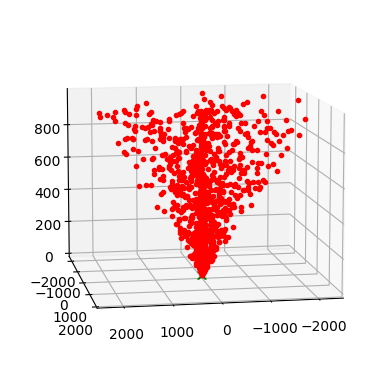

In [6]:
def random_sample_test1():
    trand = rn.uniform(0, 1e3)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf[0]
        yrand = xf[1]
    elif not sample_goal:
        rmax = vmax*trand
        sample_theta = rn.uniform(0, np.pi*2)
        sample_range = rn.uniform(0, rmax)
        xrand = sample_range*np.cos(sample_theta)
        yrand = sample_range*np.sin(sample_theta)
    return [xrand, yrand, trand]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x0[0], x0[1], 0, 'xg')
ax.plot3D(xf[0], xf[1], 0, 'xg')
time_vec = []
for i in range(1000):
    start_time = time.time()
    qsample = random_sample_test1()
    time_vec.append(time.time()-start_time)
    ax.plot3D(qsample[0], qsample[1], qsample[2], '.r')
print(np.mean(time_vec))

ax.view_init(elev=10., azim=80)

In [7]:
def random_sample():
    n = 1
    trand = rn.uniform(0, 1e3)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf[0]
        yrand = xf[1]
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0[0], 0]
        point2 = [-vmax/2*(trand - 1/vmax*(xf[0]+x0[0])), -1/vmax*(-vmax/2*(trand - 1/vmax*(xf[0]+x0[0])))+x0[0]/vmax]
        point3 = [vmax/2*(trand + 1/vmax*(xf[0]+x0[0])), 1/vmax*(vmax/2*(trand + 1/vmax*(xf[0]+x0[0]))) - x0[0]/vmax]
        point4 = [x0[1], 0]
        point5 = [-vmax/2*(trand - 1/vmax*(xf[1]+x0[1])), -1/vmax*(-vmax/2*(trand - 1/vmax*(xf[1]+x0[1])))+x0[1]/vmax]
        point6 = [vmax/2*(trand + 1/vmax*(xf[1]+x0[1])), 1/vmax*(vmax/2*(trand + 1/vmax*(xf[1]+x0[1]))) - x0[1]/vmax]
        point = np.vstack([point2, point3, point5, point6])

        # Convex hull
        hull = ConvexHull(point)
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        yrand = rand_points[0][1]
        
    return [xrand, yrand, trand]

0.0001240062713623047


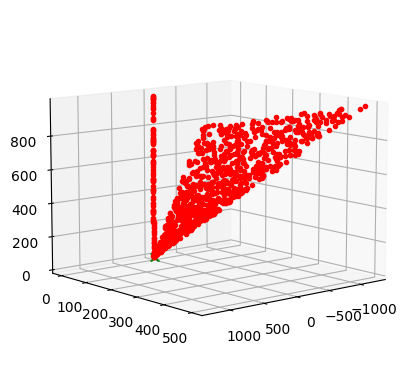

In [8]:
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x0[0], x0[1], 0, 'xg')
ax.plot3D(xf[0], xf[1], 0, 'xg')
time_vec = []
for i in range(1000):
    start_time = time.time()
    qsample = random_sample()
    time_vec.append(time.time()-start_time)
    ax.plot3D(qsample[0], qsample[1], qsample[2], '.r')
print(np.mean(time_vec))

ax.view_init(elev=10., azim=50)

In [9]:
def random_sample_test2():
    n = 1
    trand = rn.uniform(0, 250)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf[0]
        yrand = xf[1]
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0[0], 0]
        point2 = [0, x0[0]/vmax]
        point3 = [map_size[0], (map_size[0]-x0[0])/vmax]
        # point4 = [0, (map_size[0]-x0[0])/vmax]
        point4 = [0, trand]
        point5 = [map_size[0], trand]
        pos = [point1, point2, point3, point4, point5]

        # Convex hull
        hull = ConvexHull( pos )
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
        # yrand = rn.uniform(-vmax/2*(trand - 1/vmax*(xf[0]+x0[0])), vmax/2*(trand - 1/vmax*(xf[0]+x0[0])))
        yrand = rn.uniform(np.min([0, x0[0]/vmax]), np.min([vmax*(trand+x0[0]/vmax), map_size[1]]))

    # print('xrand, trand: ', xrand, trand)
    return [xrand, yrand, trand]

In [10]:
def reachable(q0, q1):
    dx = np.abs(q1[0]-q0[0])
    dy = np.abs(q1[1]-q0[1])
    dd = np.sqrt(dx**2 + dy**2)
    dt = q1[2]-q0[2]

    if dt > 0 and dd/dt <= vmax:
        return True
    else:
        return False

In [11]:
def find_neighbor(qrand, V):
    # Find Neighbor
    dist_vec = []
    for vi in V:
        if reachable(vi, qrand):
            dist_vec.append(distance(vi, qrand))
        else:
            dist_vec.append(1e1000)
    if len(dist_vec) > 0:
        closestIndex = dist_vec.index(min(dist_vec))
        qclosest = V[closestIndex]
        return qclosest
    else:
        return None

In [12]:
def extend(q0, q1, max_time):
    dx = q1[0]-q0[0]
    dy = q1[1]-q0[1]
    dt = q1[2]-q0[2]
    max_distance = max_time

    if np.abs(dx)<=max_distance and \
       np.abs(dy)<=max_distance and \
       np.abs(dt)<=max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2+dy**2+dt**2)
        dxnorm = dx/norm*vmax
        dynorm = dy/norm*vmax
        dtnorm = dt/norm*vmax
        qnew = [q0[0]+dxnorm, q0[1]+dynorm, q0[2]+dtnorm]
    return qnew

In [13]:
def validate(q):
    # True:  No violation
    # False: Violation detected
    tGiven = q[2]
    qpoint = Point(q[0], q[1])

    checkInMap = []
    # Check for map
    # Check if x coordinate is OK
    if q[0] >= 0 and q[0] <= map_size[0]:
        # Check if y coordinate is OK
        if q[1] >= 0 and q[1] <= map_size[1]:
            checkInMap = False
        else:
            checkInMap = True
    else:
        checkInMap = True
    
    checkStatic = []
    # Check for static
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(static_polygon.contains(qpoint))

    checkDynamic = []
    # Check for dynamic
    for i in range(cam_dict['n']):
        cameras = dmap.gen_cam(i, tGiven)
        cam_i = cameras[str(i)]['FOV_Poly']
        checkDynamic.append(cam_i.contains(geometry.Point(q[0],q[1])))

    # print('checkInMap: ', checkInMap)
    # print('checkStatic: ', checkStatic)
    # print('checkDynamic: ', checkDynamic)
    return not (bool(checkInMap) and bool(np.sum(checkStatic)) and bool(np.sum(checkDynamic)))

In [14]:
def check_route(q1, q2):
    route_check = []
    line = geometry.LineString([q1, q2])

    checkStatic = []
    #check for static
    # False: No collision
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(line.intersects(static_polygon))

    checkDynamic = []
    # check for dynamic
    # False: No collision
    timeVectorToCheck = np.linspace(q1[2], q2[2], 101)
    for tGiven in timeVectorToCheck:
        for i in range(cam_dict['n']):
            # TODO
            # get FOV and check geometric containment
            cameras = dmap.gen_cam(i, tGiven)
            cam_i = cameras[str(i)]['FOV_Poly']
            checkDynamic.append(line.intersects(cam_i))

    # False: Collision
    # True: No Collision
    # print(bool(np.sum(checkStatic)))
    # print(bool(np.sum(checkDynamic)))
    # print(not(bool(np.sum(checkStatic))) and not(bool(np.sum(checkDynamic))))

    # True: No collision
    # False: Collison
    if not(bool(np.sum(checkStatic))) and not(bool(np.sum(checkDynamic))):
        # Collison-free
        return True
    else:
        return False


In [15]:
# TODO
# 3. Finish making ppt and send to Hwang (ask for meeting on Monday/Tuesday)
#  -> add parts after March -> computational complexity w/ kd tree, more experiment, etc
#  -> Remake animation for 1D parallel sampling RRT (THUR/FRI)
# 4. Write up kd-tree (MON?)
# 5. Finish ST-RRT* (Friday/Weekend)
# 6. Try to get camera turret operating on linux (Weekend)

In [16]:
def find_path(xf, E):
    path = []
    path.append(E[-1][1])
    currentNode = E[-1][1]
    iter = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if currentNode[0]==e[0] and \
                currentNode[1]==e[1] and \
                currentNode[2]==e[2]:
                currentNode = E[ei][0]
                path.append(currentNode)
                break
        iter += 1
        if currentNode[0]==x0[0] and \
            currentNode[1]==x0[1] and \
            currentNode[2]==0:
            return path

In [42]:
"""Standard RRT* in 2D Space-Time"""
time_vec = []
RRT_total_time = []
RRT_total_distance = []
succeed_trials = 0
iter = 0
iter_max = 1
# K = 100

while iter < iter_max:
    print('iter: ', iter)
    start = time.time()
    k = 0
    V_RRT = []
    V_RRT.append([x0[0], x0[1], 0])
    T_RRT = []
    T_RRT.append(0)
    E_RRT = []
    V_RRT_raw = []
    V_RRT_raw.append([x0[0], x0[1], 0])

    path_RRT = None
    # while k < K:
    while 1:
        print(k)
        while 1:
            qrand = random_sample_test2()
            qclosest = find_neighbor(qrand, V_RRT)
            if qclosest is not None:
                qnew = extend(qclosest, qrand, max_time)
                
                # Validate
                validationCheck = validate(qnew)
                if validationCheck is True and check_route(qclosest, qrand) is True:
                    break
        k += 1
        V_RRT.append(qnew)
        E_RRT.append([qclosest, qnew])
        T_RRT.append(qnew[2])
        V_RRT_raw.append(qrand)

        # Check to continue:
        distanceCheck = []
        if np.abs(distance(xf, qnew)) <= 1e-2:
            distanceCheck.append(1)
        else:
            distanceCheck.append(0)

        if np.sum(distanceCheck) > 0:
            print('Path Found')
            distanceToXf = distance(xf, qnew)
            qfin = [xf[0], xf[1], qnew[2]+np.abs(distanceToXf/vmax)]
            V_RRT.append(qfin)
            E_RRT.append([qnew, qfin])
            path_RRT = find_path(xf, E_RRT)
            succeed_trials += 1
            total_path_time = 0
            total_path_distance = 0
            for fpv in range(len(path_RRT)-1):
                total_path_time+=(path_RRT[fpv+1][2]-path_RRT[fpv][2])
                total_path_distance+=distance(path_RRT[fpv+1], path_RRT[fpv])
            RRT_total_time.append(total_path_time)
            RRT_total_distance.append(total_path_distance)
            path_RRT.reverse()
        
            break
    computationTimeDuration = time.time()-start
    time_vec.append(computationTimeDuration)
    iter += 1

iter:  0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
2

In [24]:
def matchTimestep(tvec, p):
    for i in range(len(tvec)):
        tii = tvec[i]
        if p[2]-tii <= 1e-1:
            return i

In [43]:
maximumTimeSample = np.max(T_RRT)
smoothTimeVec = np.linspace(0, np.max(T_RRT), 1000)

matchingIndexForPath = []
# matchingIndexForPath.append(0)
iprev = 0
for i in range(len(path_RRT)):
    matched = matchTimestep(smoothTimeVec, path_RRT[i])
    matchingIndexForPath.append(matched)

quak = []
kek = []
for i in range(len(matchingIndexForPath)-1):
    toAppend = np.ones(matchingIndexForPath[i+1]-matchingIndexForPath[i])*i
    quak.append(matchingIndexForPath[i+1]-matchingIndexForPath[i])
    for j in range(len(toAppend)):
        kek.append(toAppend[j])
toAppend = np.ones(len(smoothTimeVec)-len(kek))*(len(path_RRT)-1)
quak.append(len(smoothTimeVec)-len(kek))
for j in range(len(toAppend)):
    kek.append(toAppend[j])


# Interpolate
xinterpolateVec=[]
yinterpolateVec=[]
tinterpolateVec = []
xinterpolateVec.append(path_RRT[0][0])
yinterpolateVec.append(path_RRT[0][1])
tinterpolateVec.append(path_RRT[0][2])
k = 0
counter = 1
for i in range(len(smoothTimeVec)-1):
    currPos = path_RRT[k]
    nextPos = path_RRT[k+1]
    xinterpolate = (nextPos[0]-currPos[0])/quak[k]*counter + currPos[0]
    yinterpolate = (nextPos[1]-currPos[1])/quak[k]*counter + currPos[1]
    tinterpolate = (nextPos[2]-currPos[2])/quak[k]*counter + currPos[2]
    # print(quak[k])
    # print(len(kek[:i]))
    # print(nextPos, currPos)
    # print(xinterpolate, yinterpolate)
    xinterpolateVec.append(xinterpolate)
    yinterpolateVec.append(yinterpolate)
    tinterpolateVec.append(tinterpolate)
    
    counter+=1
    if i == np.sum(quak[:k+1]) and k <= 100:
        print(k)
        k+=1
        counter=0
        xinterpolateVec.append(path_RRT[k][0])
        yinterpolateVec.append(path_RRT[k][1])
        tinterpolateVec.append(path_RRT[k][2])
        currPos = path_RRT[k]
        nextPos = path_RRT[k+1]
        # print(currPos, nextPos)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


IndexError: list index out of range

(0.0, 20.0)

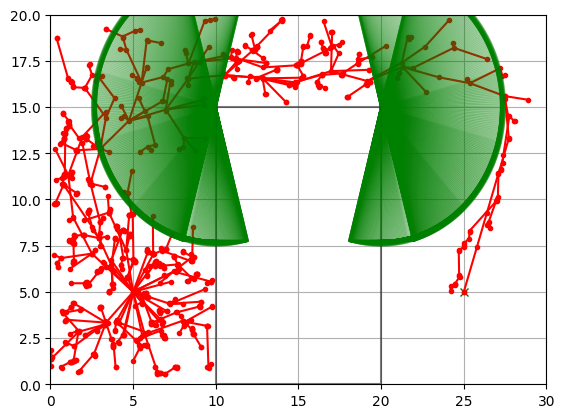

In [44]:
fig = plt.figure()
plt.plot(x0[0], x0[1], 'xg')
plt.plot(xf[0], xf[1], 'xg')
for v in V_RRT:
    plt.plot(v[0], v[1], '.r')
for e in E_RRT:
    plt.plot([e[0][0],e[1][0]],[e[0][1],e[1][1]], '-r')
building_alpha = 0.5
for ii in range(map_in['st']['n']):
    ibuilding = map_in['st'][str(ii)]
    wall = geometry.LineString(ibuilding)
    building = geometry.Polygon(wall)
    bx,by = building.exterior.xy
    plt.plot(bx, by, '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
time_index = np.linspace(0, maximumTimeSample, len(T_RRT))
for t in time_index:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, t)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, cy, '-g', alpha=0.1)
plt.grid()
# Plot Limits
ax.axis('square')
plt.xlim(0, map_size[0])
plt.ylim(0, map_size[1])

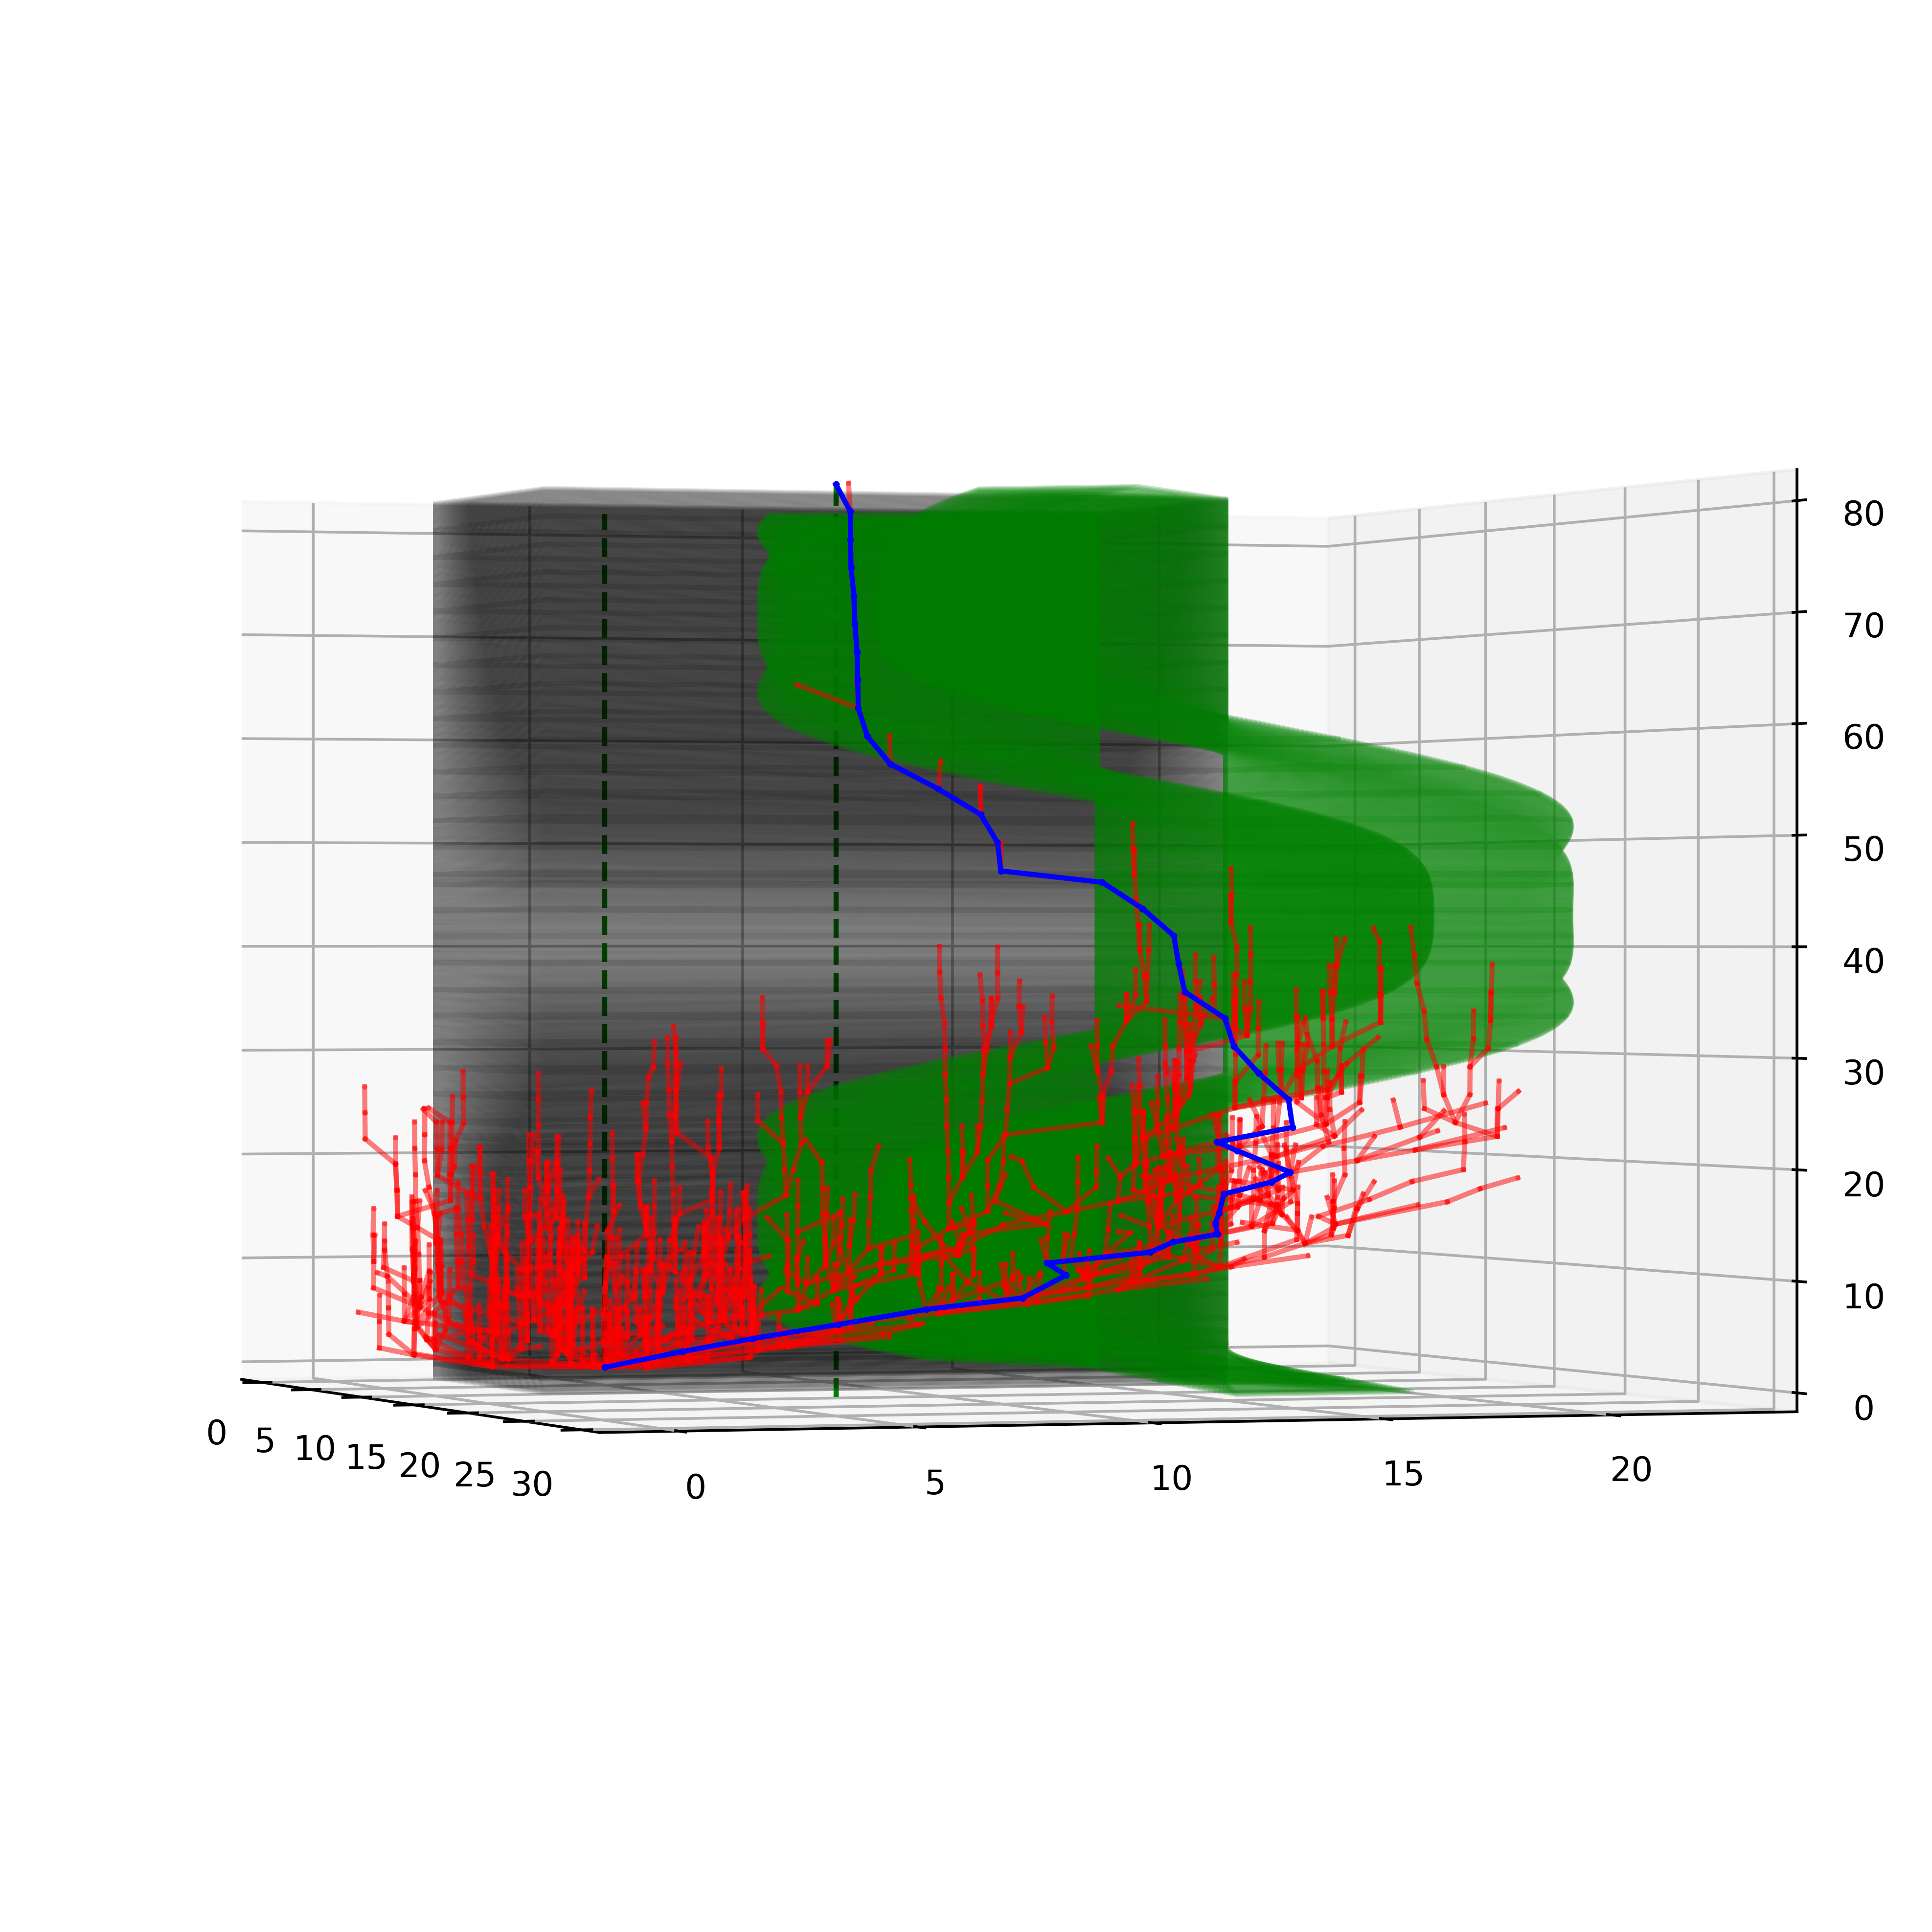

In [36]:
fig = plt.figure(figsize=(10, 10), dpi=500)
ax = fig.add_subplot(111, projection='3d')
ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [0, maximumTimeSample], '--g', markersize=5)
ax.plot3D([xf[0], xf[0]], [xf[1], xf[1]], [0, maximumTimeSample], '--g', markersize=5)

building_alpha = 0.1
for ti in tinterpolateVec:
    for ii in range(map_in['st']['n']):
        ibuilding = map_in['st'][str(ii)]
        wall = geometry.LineString(ibuilding)
        building = geometry.Polygon(wall)
        bx,by = building.exterior.xy
        ax.plot3D(bx, by, np.ones(len(bx))*ti, '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
for ti in tinterpolateVec:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, ti)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        ax.plot3D(cx, cy, np.ones(len(cx))*ti, '-g', alpha=.2)

for v in V_RRT:
    ax.plot3D(v[0], v[1], v[2], '.r', markersize=1, alpha=0.5)
for e in E_RRT:
    ax.plot3D([e[0][0],e[1][0]],[e[0][1],e[1][1]],[e[0][2],e[1][2]], '-r', alpha=0.5)
for p in path_RRT:
    ax.plot3D(p[0], p[1], p[2], '.b', markersize=2, alpha=1)
for pe in range(len(path_RRT)-1):
    p1 = path_RRT[pe]
    p2 = path_RRT[pe+1]
    ax.plot3D([p1[0],p2[0]],[p1[1],p2[1]],[p1[2],p2[2]], '-b', markersize=2, alpha=1)
        
ax.view_init(elev=0., azim=-20)


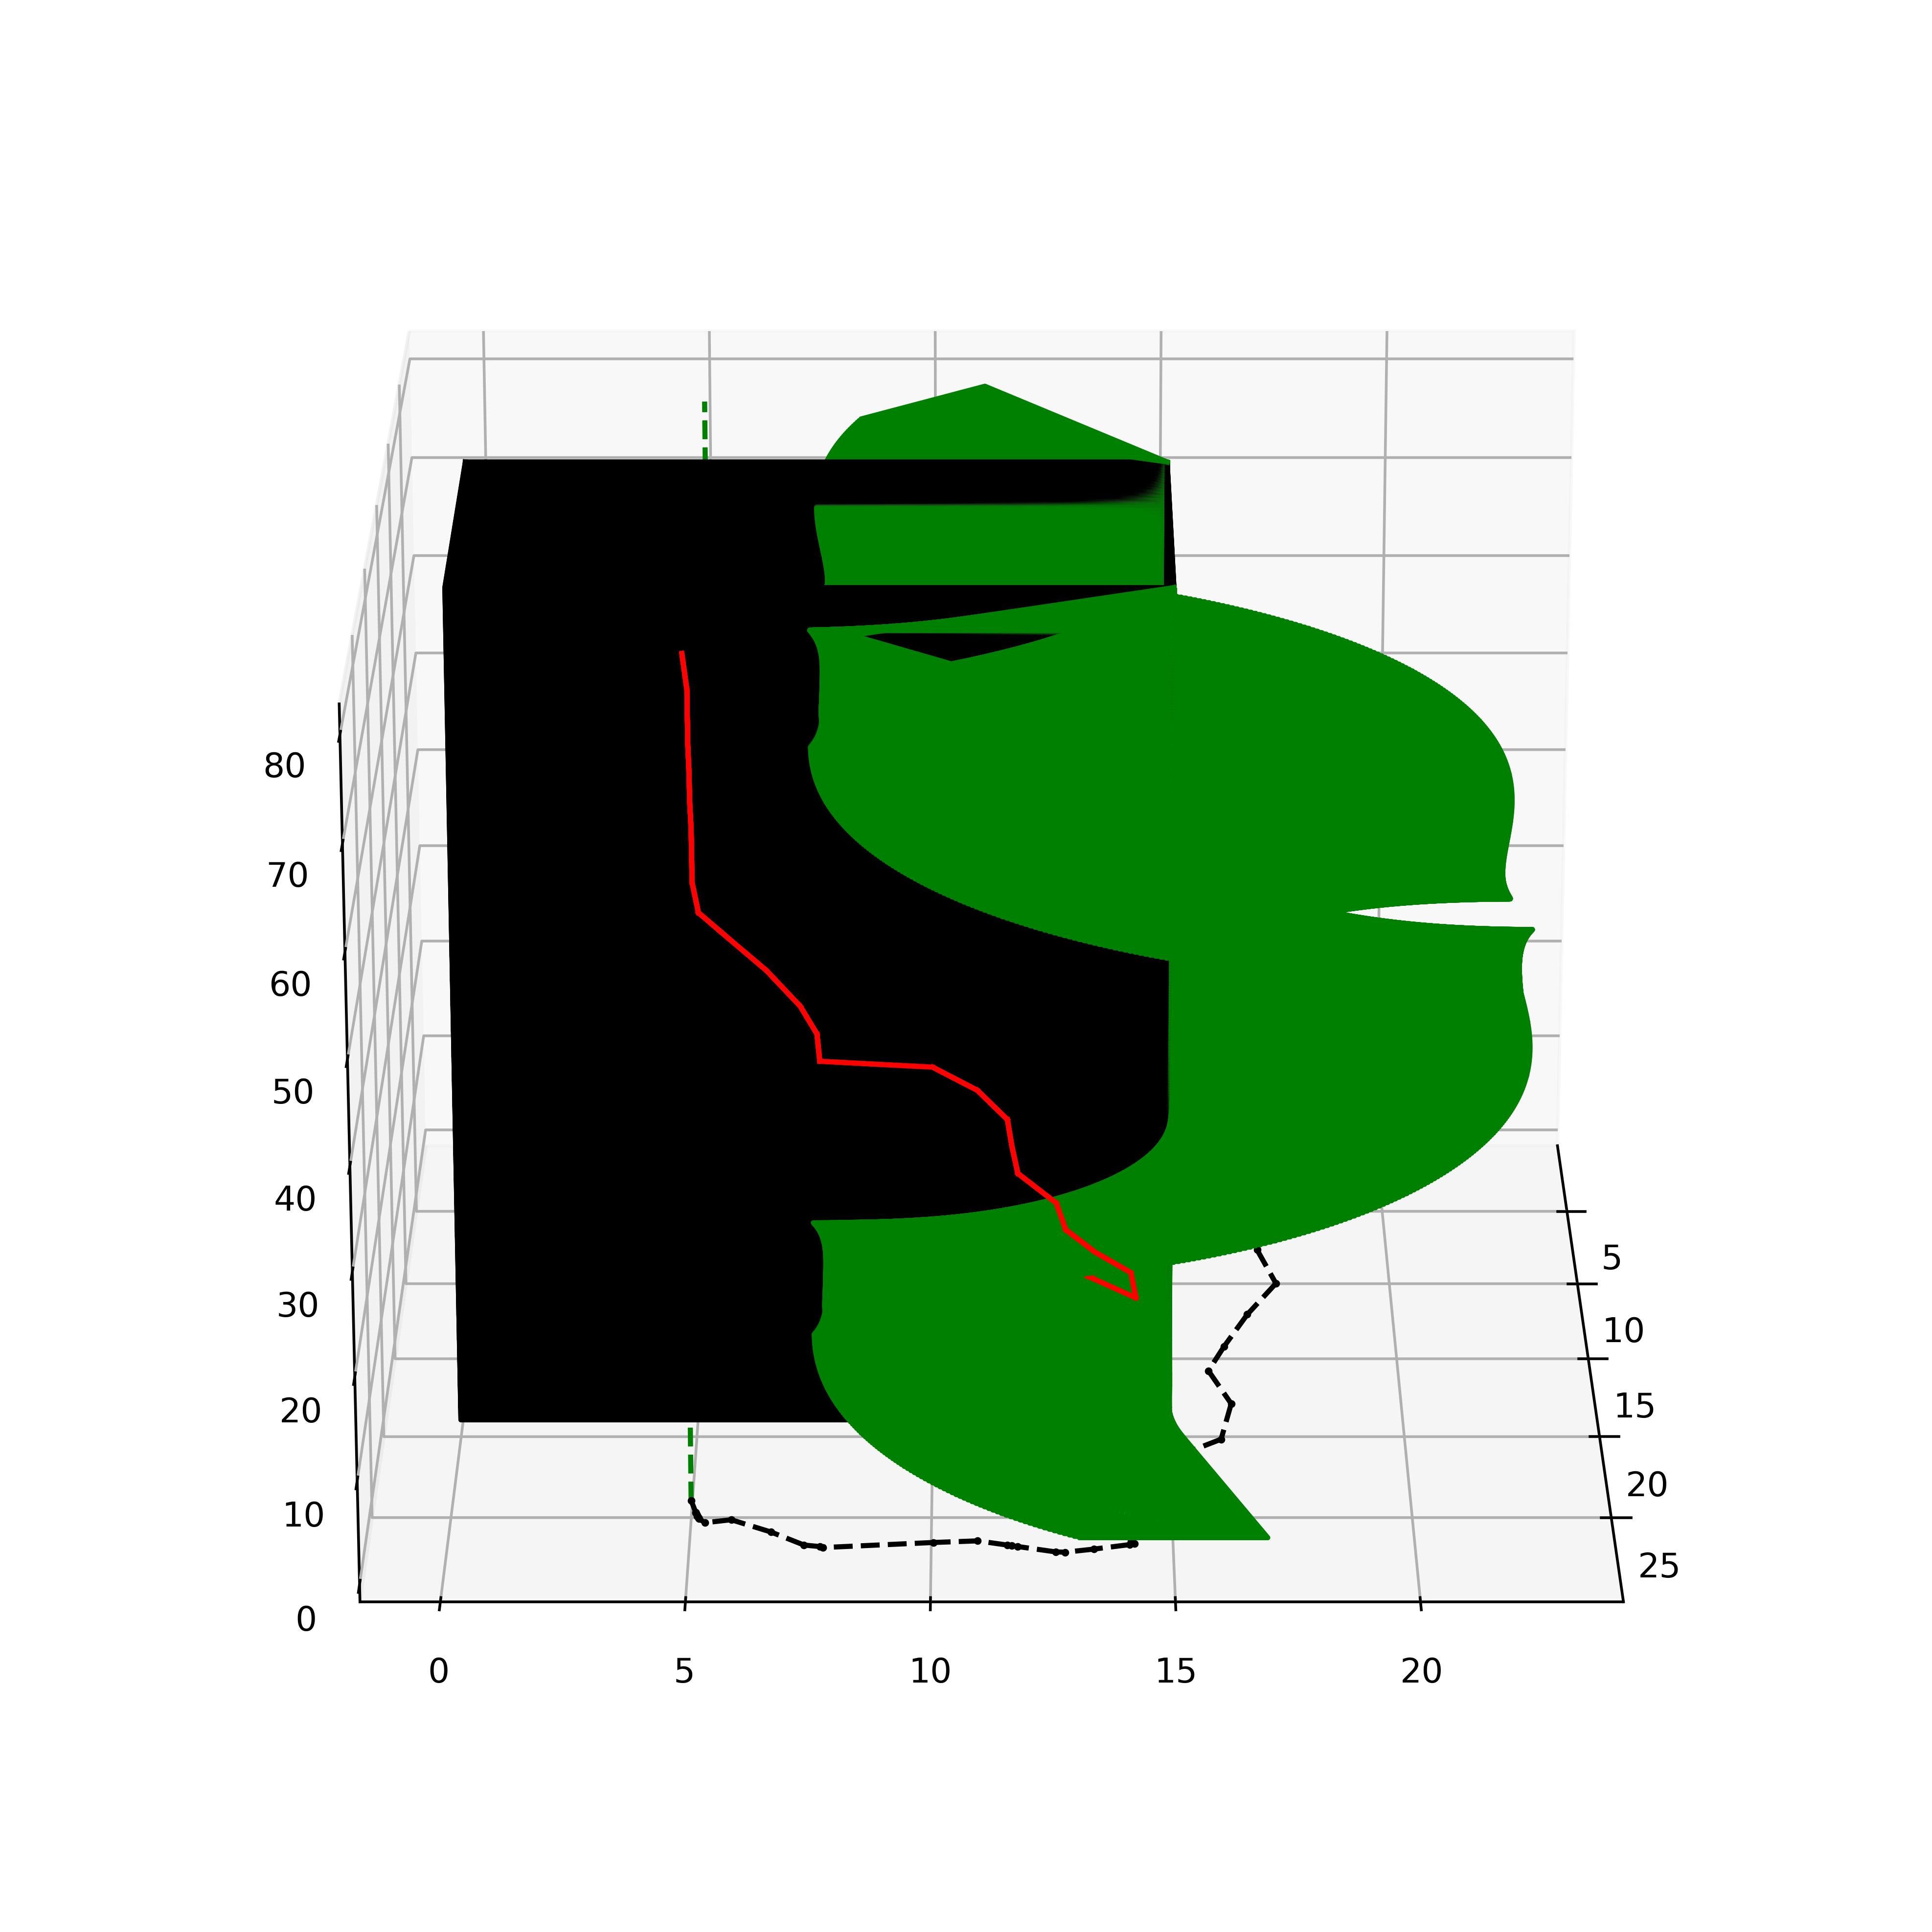

In [37]:
fig = plt.figure(figsize=(10, 10), dpi=500)
ax = fig.add_subplot(111, projection='3d')
ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [0, maximumTimeSample], '--g', markersize=5)
ax.plot3D([xf[0], xf[0]], [xf[1], xf[1]], [0, maximumTimeSample], '--g', markersize=5)
for p in path_RRT:
    plt.plot(p[0], p[1], '.k', markersize=2.5)
for i in range(len(path_RRT)-1):
    pi = path_RRT[i]
    pii = path_RRT[i+1]
    plt.plot([pi[0], pii[0]], [pi[1], pii[1]], '--k', markersize=2.5)

for i in range(len(tinterpolateVec)-1):
    building_alpha = 1
    ti = tinterpolateVec[i]
    for ii in range(map_in['st']['n']):
        ibuilding = map_in['st'][str(ii)]
        wall = geometry.LineString(ibuilding)
        building = geometry.Polygon(wall)
        bx,by = building.exterior.xy
        ax.plot3D(bx, by, np.ones(len(bx))*ti, '-', color='k', alpha=building_alpha)

    # Plot Cameras
    dmap = map_in['dy']
    for ii in range(2):
        cameras = dmap.gen_cam(ii, ti)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        ax.plot3D(cx, cy, np.ones(len(cx))*ti, '-g', alpha=1)

    # ax.plot3D(xinterpolateVec[i], yinterpolateVec[i], tinterpolateVec[i], '.r', alpha=1, markersize=10)
    ax.plot3D([xinterpolateVec[i], xinterpolateVec[i+1]], [yinterpolateVec[i], yinterpolateVec[i+1]], [tinterpolateVec[i], tinterpolateVec[i+1]], '-r', alpha=1, markersize=2.5)
        
ax.view_init(elev=20, azim=0)


100
0/99
0/99
1/99
2/99
3/99
4/99
5/99
6/99
7/99
8/99
9/99
10/99
11/99
12/99
13/99
14/99
15/99
16/99
17/99
18/99
19/99
20/99
21/99
22/99
23/99
24/99
25/99
26/99
27/99
28/99
29/99
30/99
31/99
32/99
33/99
34/99
35/99
36/99
37/99
38/99
39/99
40/99
41/99
42/99
43/99
44/99
45/99
46/99
47/99
48/99
49/99
50/99
51/99
52/99
53/99
54/99
55/99
56/99
57/99
58/99
59/99
60/99
61/99
62/99
63/99
64/99
65/99
66/99
67/99
68/99
69/99
70/99
71/99
72/99
73/99
74/99
75/99
76/99
77/99
78/99
79/99
80/99
81/99
82/99
83/99
84/99
85/99
86/99
87/99
88/99
89/99
90/99
91/99
92/99
93/99
94/99
95/99
96/99
97/99
98/99
99/99
100/99
101/99
102/99
103/99
104/99
105/99
106/99
107/99
108/99
109/99
110/99
111/99
112/99
113/99
114/99
115/99
116/99
117/99
118/99
119/99
120/99
121/99
122/99
123/99
124/99
125/99
126/99
127/99
0/99


/tmp/ipykernel_10315/2785961127.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

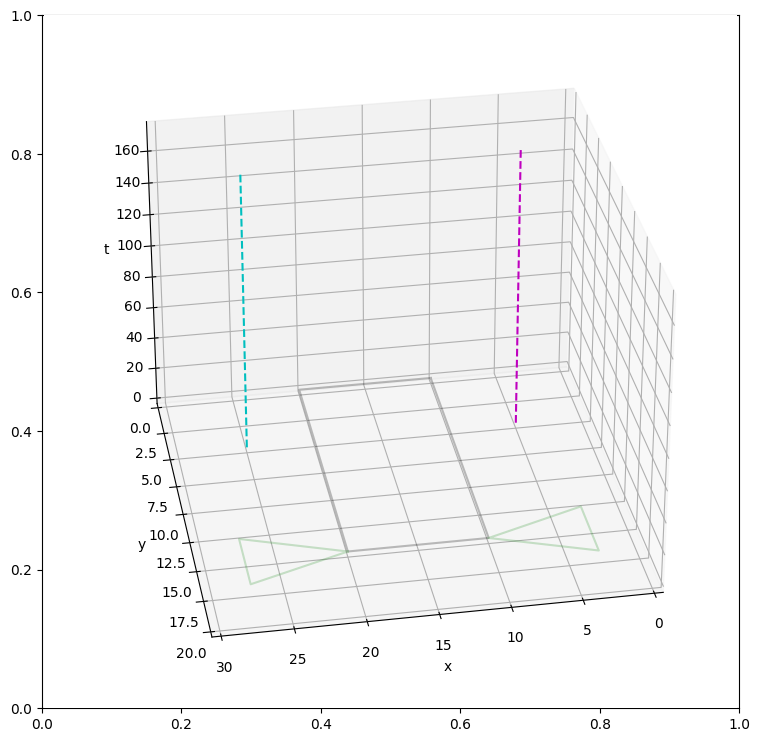

In [ ]:
from matplotlib.animation import FuncAnimation
# Total points
total_points = 0
total_points += len(V_RRT)
print(total_points)
view_rotation_angle_vector = np.linspace(80, -80, total_points)

# Timelaps 
plt.clf()
figure, ax = plt.subplots(figsize=(9, 9), dpi=(100))
ax = plt.axes(projection='3d')

# Since plotting a single graph
def animation_function(i):
    plt. cla()
    # time_index = np.linspace(0, np.max(T_RRT[:i+1]), len(T_RRT[:i])+1)
    maxTimeSamplei = np.max(T_RRT[:i+1])
    T_RRTSegment = T_RRT[:i+1]
    T_RRTSegment.sort()
    
    building_alpha = 0.25
    for ti in T_RRTSegment:
        for ii in range(map_in['st']['n']):
            ibuilding = map_in['st'][str(ii)]
            wall = geometry.LineString(ibuilding)
            building = geometry.Polygon(wall)
            bx,by = building.exterior.xy
            plt.plot(bx, by, np.ones(len(bx))*ti, '-', color='k', alpha=building_alpha)
    print(str(i)+'/'+str(len(V_RRT)-1))
    i = int(i)
    # Initial/Final
    ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [0, max(T_RRT)+5], 'm--', alpha=1)
    ax.plot3D([xf[0], xf[0]], [xf[1], xf[1]], [0, max(T_RRT)+5], 'c--', alpha=1)

    # Plot Cameras
    dmap = map_in['dy']
    for ti in T_RRTSegment:
        for ii in range(2):
            cameras = dmap.gen_cam(ii, ti)
            ncam = cameras['n']
            cam_i = cameras[str(ii)]['FOV_Poly']
            cx, cy = cam_i.exterior.xy
            plt.plot(cx, cy, ti, '-g', alpha=0.2)

    for v in V_RRT[:i]:
        ax.plot3D(v[0], v[1], v[2], '.r', markersize=1, alpha=0.5)
    for e in E_RRT[:i]:
        ax.plot3D([e[0][0], e[1][0]], [e[0][1], e[1][1]], [e[0][2], e[1][2]], '-r', markersize=1, alpha=0.5)
    if i >=  len(V_RRT)+1:
        # print('Plotting Path')
        # ii = i-len(V_RRT)
        # for pathi in path_RRT[:ii]:
        #     ax.plot3D(pathi[0], pathi[1], pathi[2], '.b', markersize=3)
        # for pathi in range(len(path_RRT[:ii])-1):
        #     ax.plot3D([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], [path_RRT[pathi][2], path_RRT[pathi+1][2]], '-b', markersize=3)
        
        for pathi in path_RRT:
            ax.plot3D(pathi[0], pathi[1], pathi[2], '.b', markersize=3)
        for pathi in range(len(path_RRT)-1):
            ax.plot3D([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], [path_RRT[pathi][2], path_RRT[pathi+1][2]], '-b', markersize=3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')
    ax.set_xlim(0, map_size[0])
    ax.set_ylim(0, map_size[1])
    # ax.set_zlim(0, maxTimeSamplei)
    if i >=  len(V_RRT):
        ax.view_init(elev=30, azim=40)
    else:
        ax.view_init(elev=30, azim=view_rotation_angle_vector[i])

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, len(V_RRT)+len(path_RRT), 1), 
                        #   frames = np.arange(0, 50, 1), 
                        #   frames = np.arange(len(V_RRT)+100, len(V_RRT)+len(path_RRT), 1), 
                          interval = 100)
animation.save('2D_RRT_Example01.mp4', writer="ffmpeg")
fig.show()

(0.0, 20.0)

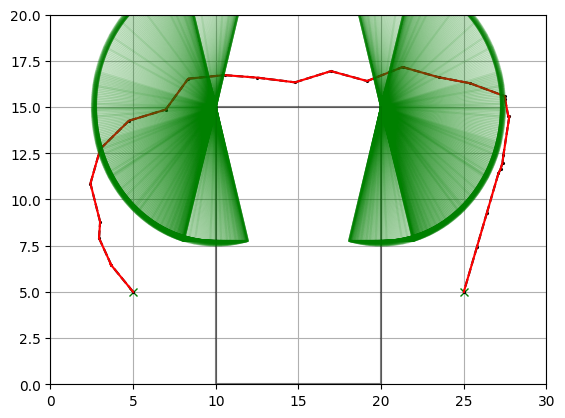

In [45]:
fig = plt.figure()
plt.plot(x0[0], x0[1], 'xg')
plt.plot(xf[0], xf[1], 'xg')
# for v in V_RRT[:2]:
#     plt.plot(v[0], v[1], '.r')
# for e in E_RRT[:2]:
#     plt.plot([e[0][0],e[1][0]],[e[0][1],e[1][1]], '-r')

for p in path_RRT:
    plt.plot(p[0], p[1], '.k', markersize=2.5)
for i in range(len(path_RRT)-1):
    pi = path_RRT[i]
    pii = path_RRT[i+1]
    plt.plot([pi[0], pii[0]], [pi[1], pii[1]], '--k', markersize=2.5)
plt.plot(xinterpolateVec, yinterpolateVec, '-r', alpha=1, markersize=10)

building_alpha = 0.5
for ii in range(map_in['st']['n']):
    ibuilding = map_in['st'][str(ii)]
    wall = geometry.LineString(ibuilding)
    building = geometry.Polygon(wall)
    bx,by = building.exterior.xy
    plt.plot(bx, by, '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
for t in tinterpolateVec:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, t)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, cy, '-g', alpha=0.1)
plt.grid()
# Plot Limits
ax.axis('square')
plt.xlim(0, map_size[0])
plt.ylim(0, map_size[1])

(0.0, 78.9575768856559)

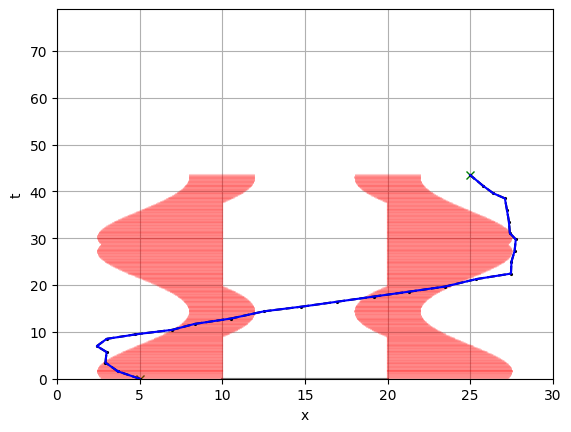

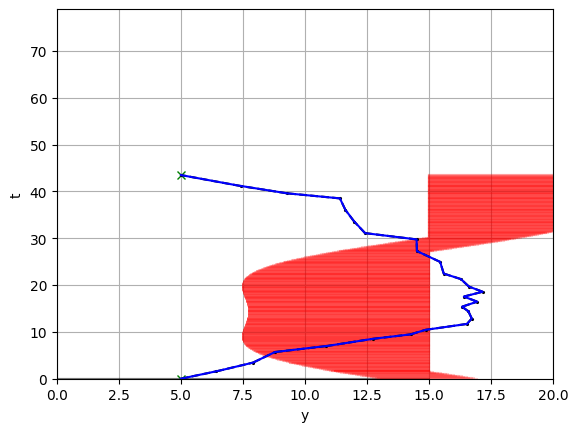

In [46]:
fig = plt.figure()
plt.plot(x0[0], 0, 'xg')
plt.plot(xf[0], path_RRT[-1][2], 'xg')

building_alpha = 0.5
for ii in range(map_in['st']['n']):
    ibuilding = map_in['st'][str(ii)]
    wall = geometry.LineString(ibuilding)
    building = geometry.Polygon(wall)
    bx,by = building.exterior.xy
    plt.plot(bx, np.ones(len(by))*path_RRT[ii][2], '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
for t in tinterpolateVec:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, t)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, np.ones(len(cy))*t, '-r', alpha=.1)

for p in path_RRT:
    plt.plot(p[0], p[2], '.k', markersize=2.5)
for i in range(len(path_RRT)-1):
    pi = path_RRT[i]
    pii = path_RRT[i+1]
    plt.plot([pi[0], pii[0]], [pi[2], pii[2]], '--k', markersize=2.5)
plt.plot(xinterpolateVec, tinterpolateVec, '-b', alpha=1, markersize=10)


plt.grid()
# Plot Limits
ax.axis('square')
plt.xlabel('x')
plt.ylabel('t')
plt.xlim(0, map_size[0])
plt.ylim(0, np.max(T_RRT))

fig = plt.figure()
plt.plot(x0[1], 0, 'xg')
plt.plot(xf[1], path_RRT[-1][2], 'xg')

building_alpha = 0.5
for ii in range(map_in['st']['n']):
    ibuilding = map_in['st'][str(ii)]
    wall = geometry.LineString(ibuilding)
    building = geometry.Polygon(wall)
    bx,by = building.exterior.xy
    plt.plot(by, np.ones(len(bx))*path_RRT[ii][2], '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
# time_index = extractedTimefromPath
for t in tinterpolateVec:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, t)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cy, np.ones(len(cx))*t, '-r', alpha=0.1)

for p in path_RRT:
    plt.plot(p[1], p[2], '.k', markersize=2.5)
for i in range(len(path_RRT)-1):
    pi = path_RRT[i]
    pii = path_RRT[i+1]
    plt.plot([pi[1], pii[1]], [pi[2], pii[2]], '--k', markersize=2.5)
plt.plot(yinterpolateVec, tinterpolateVec, '-b', alpha=1, markersize=10)

plt.grid()
# Plot Limits
ax.axis('square')
plt.xlabel('y')
plt.ylabel('t')
plt.xlim(0, map_size[1])
plt.ylim(0, np.max(T_RRT))

579
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


/tmp/ipykernel_35804/1249253324.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0


<Figure size 640x480 with 0 Axes>

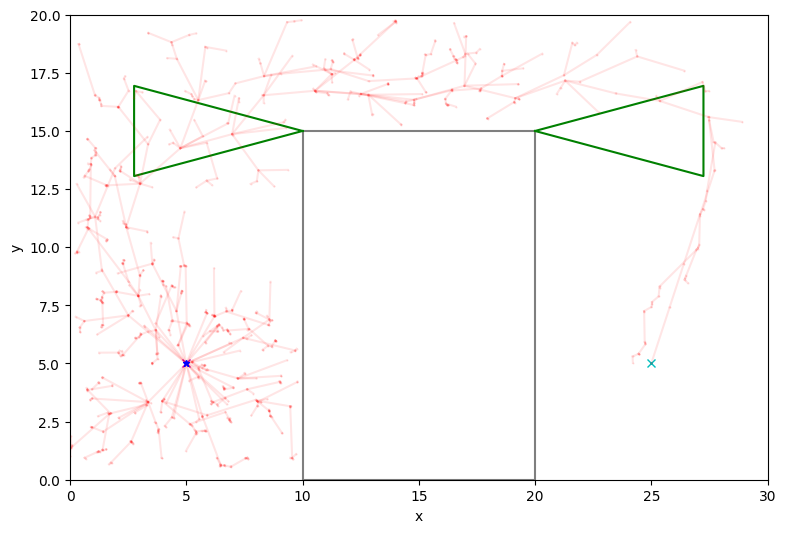

In [47]:
from matplotlib.animation import FuncAnimation
# Total points
total_points = 0
total_points += len(xinterpolateVec)
print(total_points)
view_rotation_angle_vector = np.linspace(80, -80, total_points)

# Timelaps 
plt.clf()
figure, ax = plt.subplots(figsize=(9, 9), dpi=(100))
k = 0

# Since plotting a single graph
def animation_function(i):
    plt. cla()
    # time_index = np.linspace(0, np.max(T_RRT[:i+1]), len(T_RRT[:i])+1)
    T_RRTSegment = T_RRT[:i+1]
    T_RRTSegment.sort()
    
    building_alpha = 0.5
    for ii in range(map_in['st']['n']):
        ibuilding = map_in['st'][str(ii)]
        wall = geometry.LineString(ibuilding)
        building = geometry.Polygon(wall)
        bx,by = building.exterior.xy
        plt.plot(bx, by, '-', color='k', alpha=building_alpha)
    print(i)
    i = int(i)
    # Initial/Final
    plt.plot(x0[0], x0[1], 'xm', alpha=1)
    plt.plot(xf[0], xf[1], 'xc', alpha=1)

    # Plot Cameras
    dmap = map_in['dy']
    ti = tinterpolateVec[i]
    for ii in range(2):
        cameras = dmap.gen_cam(ii, ti)
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, cy, '-g', alpha=1)

    rrt_alpha = 0.1
    for v in V_RRT:
        plt.plot(v[0], v[1], '.r', markersize=1, alpha=rrt_alpha)
    for e in E_RRT:
        plt.plot([e[0][0], e[1][0]], [e[0][1], e[1][1]], '-r', markersize=1, alpha=rrt_alpha)
    
    # Interpolated Path
    pathi = [xinterpolateVec[i], yinterpolateVec[i]]
    plt.plot(pathi[0], pathi[1], '*b', markersize=5)
    
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(0, map_size[0])
    ax.set_ylim(0, map_size[1])

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, len(xinterpolateVec), 1), 
                        #   frames = np.arange(0, 100, 1), 
                        #   frames = np.arange(len(V_RRT)+100, len(V_RRT)+len(path_RRT), 1), 
                          interval = 25)
animation.save('2D_RRT_Example01_2D_Interpolate_vmax='+str(vmax)+'_differentcamerapanspeed2'+'.mp4', writer="ffmpeg")
fig.show()

1000
0/63
0/63
1/63
2/63
3/63
4/63
5/63
6/63
7/63
8/63
9/63
10/63
11/63
12/63
13/63
14/63
15/63
16/63
17/63
18/63
19/63
20/63
21/63
22/63
23/63
24/63
25/63
26/63
27/63
28/63
29/63
30/63
31/63
32/63
33/63
34/63
35/63
36/63
37/63
38/63
39/63
40/63
41/63
42/63
43/63
44/63
45/63
46/63
47/63
48/63
49/63
50/63
51/63
52/63
53/63
54/63
55/63
56/63
57/63
58/63
59/63
60/63
61/63
62/63
63/63
64/63
65/63
66/63
67/63
68/63
69/63
70/63
71/63
72/63
73/63
74/63
75/63
76/63
77/63
78/63
79/63
80/63
81/63
82/63
83/63
84/63
85/63
86/63
87/63
88/63
89/63
90/63
91/63
92/63
93/63
94/63
95/63
96/63
97/63
98/63
99/63
100/63
101/63
102/63
103/63
104/63
105/63
106/63
107/63
108/63
109/63
110/63
111/63
112/63
113/63
114/63
115/63
116/63
117/63
118/63
119/63
120/63
121/63
122/63
123/63
124/63
125/63
126/63
127/63
128/63
129/63
130/63
131/63
132/63
133/63
134/63
135/63
136/63
137/63
138/63
139/63
140/63
141/63
142/63
143/63
144/63
145/63
146/63
147/63
148/63
149/63
150/63
151/63
152/63
153/63
154/63
155/63
156/63
1

/tmp/ipykernel_14954/2447995302.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0/63


<Figure size 640x480 with 0 Axes>

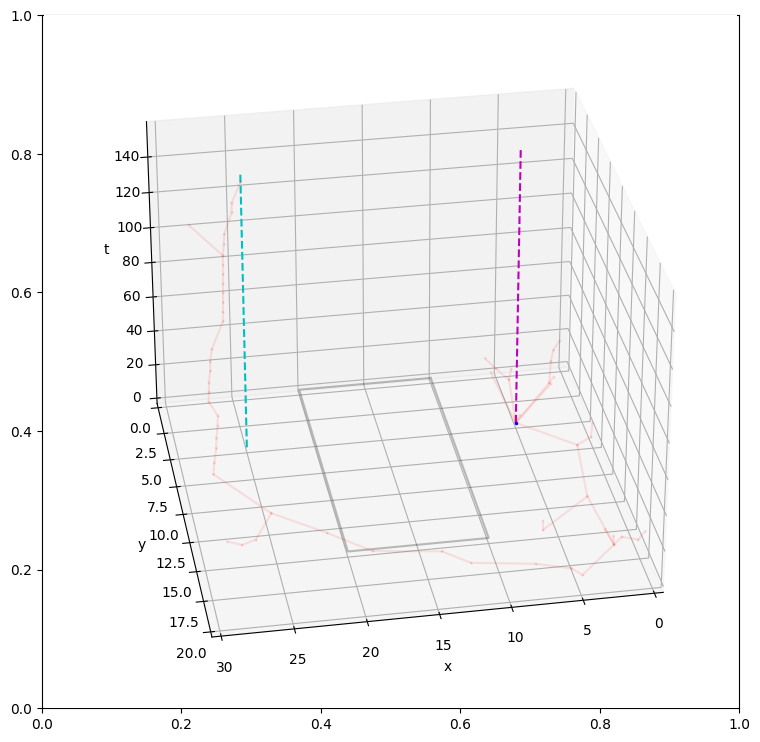

In [ ]:
from matplotlib.animation import FuncAnimation
# Total points
total_points = 0
total_points += len(smoothTimeVec)
print(total_points)
view_rotation_angle_vector = np.linspace(80, -80, total_points)

# Timelaps 
plt.clf()
figure, ax = plt.subplots(figsize=(9, 9), dpi=(100))
ax = plt.axes(projection='3d')

# Since plotting a single graph
def animation_function(i):
    plt. cla()
    # time_index = np.linspace(0, np.max(T_RRT[:i+1]), len(T_RRT[:i])+1)
    maxTimeSamplei = np.max(T_RRT[:i+1])
    T_RRTSegment = T_RRT[:i+1]
    T_RRTSegment.sort()
    
    building_alpha = 0.25
    for ti in T_RRTSegment:
        for ii in range(map_in['st']['n']):
            ibuilding = map_in['st'][str(ii)]
            wall = geometry.LineString(ibuilding)
            building = geometry.Polygon(wall)
            bx,by = building.exterior.xy
            plt.plot(bx, by, np.ones(len(bx))*ti, '-', color='k', alpha=building_alpha)
    print(str(i)+'/'+str(total_points))
    i = int(i)
    # Initial/Final
    ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [0, max(T_RRT)+5], 'm--', alpha=1)
    ax.plot3D([xf[0], xf[0]], [xf[1], xf[1]], [0, max(T_RRT)+5], 'c--', alpha=1)

    # Plot Cameras
    dmap = map_in['dy']
    for ti in smoothTimeVec[:i]:
        for ii in range(2):
            cameras = dmap.gen_cam(ii, ti)
            ncam = cameras['n']
            cam_i = cameras[str(ii)]['FOV_Poly']
            cx, cy = cam_i.exterior.xy
            plt.plot(cx, cy, ti, '-g', alpha=0.5)

    for v in V_RRT:
        ax.plot3D(v[0], v[1], v[2], '.r', markersize=1, alpha=0.1)
    for e in E_RRT:
        ax.plot3D([e[0][0], e[1][0]], [e[0][1], e[1][1]], [e[0][2], e[1][2]], '-r', markersize=1, alpha=0.1)

    ti = smoothTimeVec[i]
    pathi = path_RRT[int(kek[i])]
    ax.plot3D(pathi[0], pathi[1], pathi[2], '.b', markersize=3)
    # for pathi in range(len(path_RRT)-1):
        # ax.plot3D([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], [path_RRT[pathi][2], path_RRT[pathi+1][2]], '-b', markersize=3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')
    ax.set_xlim(0, map_size[0])
    ax.set_ylim(0, map_size[1])
    # ax.set_zlim(0, maxTimeSamplei)
    ax.view_init(elev=30, azim=view_rotation_angle_vector[i])

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, len(smoothTimeVec), 1), 
                        #   frames = np.arange(0, 50, 1), 
                        #   frames = np.arange(len(V_RRT)+100, len(V_RRT)+len(path_RRT), 1), 
                          interval = 25)
animation.save('2D_RRT_Example01_03.mp4', writer="ffmpeg")
fig.show()

27
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0


/tmp/ipykernel_14954/3298191716.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

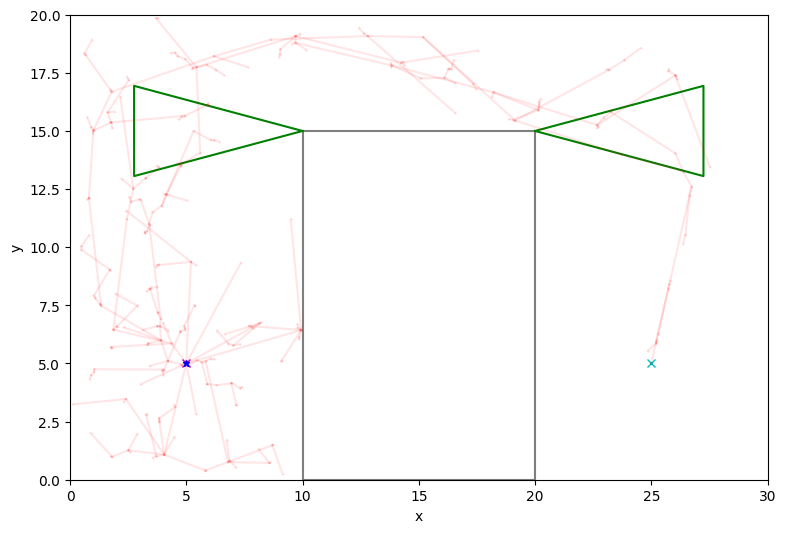

In [ ]:
from matplotlib.animation import FuncAnimation
# Total points
total_points = 0
total_points += len(path_RRT)
print(total_points)

# Timelaps 
plt.clf()
figure, ax = plt.subplots(figsize=(9, 9), dpi=(100))
k = 0

# Since plotting a single graph
def animation_function(i):
    plt. cla()
    # time_index = np.linspace(0, np.max(T_RRT[:i+1]), len(T_RRT[:i])+1)
    T_RRTSegment = T_RRT[:i+1]
    T_RRTSegment.sort()
    
    building_alpha = 0.5
    for ii in range(map_in['st']['n']):
        ibuilding = map_in['st'][str(ii)]
        wall = geometry.LineString(ibuilding)
        building = geometry.Polygon(wall)
        bx,by = building.exterior.xy
        plt.plot(bx, by, '-', color='k', alpha=building_alpha)
    print(i)
    i = int(i)
    # Initial/Final
    plt.plot(x0[0], x0[1], 'xm', alpha=1)
    plt.plot(xf[0], xf[1], 'xc', alpha=1)

    # Plot Cameras
    dmap = map_in['dy']
    ti = path_RRT[i][2]
    for ii in range(2):
        cameras = dmap.gen_cam(ii, ti)
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, cy, '-g', alpha=1)

    rrt_alpha = 0.1
    for v in V_RRT:
        plt.plot(v[0], v[1], '.r', markersize=1, alpha=rrt_alpha)
    for e in E_RRT:
        plt.plot([e[0][0], e[1][0]], [e[0][1], e[1][1]], '-r', markersize=1, alpha=rrt_alpha)
    
    pathi = path_RRT[i]
    plt.plot(pathi[0], pathi[1], '*b', markersize=5)
    # for pathi in range(len(path_RRT[:i])-1):
    #     plt.plot([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], '-b', markersize=5)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(0, map_size[0])
    ax.set_ylim(0, map_size[1])

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, len(path_RRT), 1), 
                        #   frames = np.arange(0, 150, 1), 
                        #   frames = np.arange(len(V_RRT)+100, len(V_RRT)+len(path_RRT), 1), 
                          interval = 500)
animation.save('2D_RRT_Example01_2D_View04.mp4', writer="ffmpeg")
fig.show()